# Finding Detection Mistakes with FiftyOne

Annotations mistakes create an artificial ceiling on the performance of your models. However, finding these mistakes by hand is at least as arduous as the original annotation work! Enter FiftyOne.

In this tutorial, we explore how FiftyOne can be used to help you find mistakes in your object detection annotations. To detect mistakes in classification datasets, check out [this tutorial](https://voxel51.com/docs/fiftyone/tutorials/classification_mistakes.html).

We'll cover the following concepts:

- Loading your existing dataset [into FiftyOne](https://voxel51.com/docs/fiftyone/user_guide/dataset_creation/index.html)
- [Adding model predictions](https://voxel51.com/docs/fiftyone/recipes/adding_detections.html) to your dataset
- Computing insights into your dataset relating to [possible label mistakes](https://voxel51.com/docs/fiftyone/user_guide/brain.html#label-mistakes)
- Visualizing mistakes in the [FiftyOne App](https://voxel51.com/docs/fiftyone/user_guide/app.html)

**So, what's the takeaway?**

FiftyOne can help you find and correct label mistakes in your datasets, enabling you to curate higher quality datasets and, ultimately, train better models!

## Setup

If you haven't already, install FiftyOne:

In [ ]:
!pip install fiftyone

In order to compute mistakenness, your dataset needs to have two [detections fields](https://voxel51.com/docs/fiftyone/user_guide/using_datasets.html#object-detection), one with your ground truth annotations and one with your model predictions.

In this example, we'll load the [quickstart dataset](https://voxel51.com/docs/fiftyone/user_guide/dataset_zoo/datasets.html#dataset-zoo-quickstart) from the FiftyOne Dataset Zoo, which has ground truth annotations and predictions from a [PyTorch Faster-RCNN model](https://github.com/pytorch/vision/blob/master/torchvision/models/detection/faster_rcnn.py) for a few samples from the COCO dataset.

In [1]:
import fiftyone as fo
import fiftyone.zoo as foz

dataset = foz.load_zoo_dataset("quickstart")

Dataset already downloaded
Loading 'quickstart'
 100% |█████████████████| 200/200 [3.5s elapsed, 0s remaining, 45.0 samples/s]      
Dataset 'quickstart' created


In [2]:
print(dataset)

Name:           quickstart
Media type:     image
Num samples:    200
Persistent:     False
Tags:           ['validation']
Sample fields:
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.Metadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    uniqueness:   fiftyone.core.fields.FloatField
    predictions:  fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)


In [3]:
# Print a sample ground truth detection
sample = dataset.first()
print(sample.predictions.detections[0])

<Detection: {
    'id': '5f452c60ef00e6374aad9394',
    'attributes': BaseDict({}),
    'tags': BaseList([]),
    'label': 'bird',
    'bounding_box': BaseList([
        0.22192673683166503,
        0.06093006531397502,
        0.4808845520019531,
        0.8937615712483724,
    ]),
    'mask': None,
    'confidence': 0.9750854969024658,
    'index': None,
}>


Let's start by visualizing the dataset in the [FiftyOne App](https://voxel51.com/docs/fiftyone/user_guide/app.html):


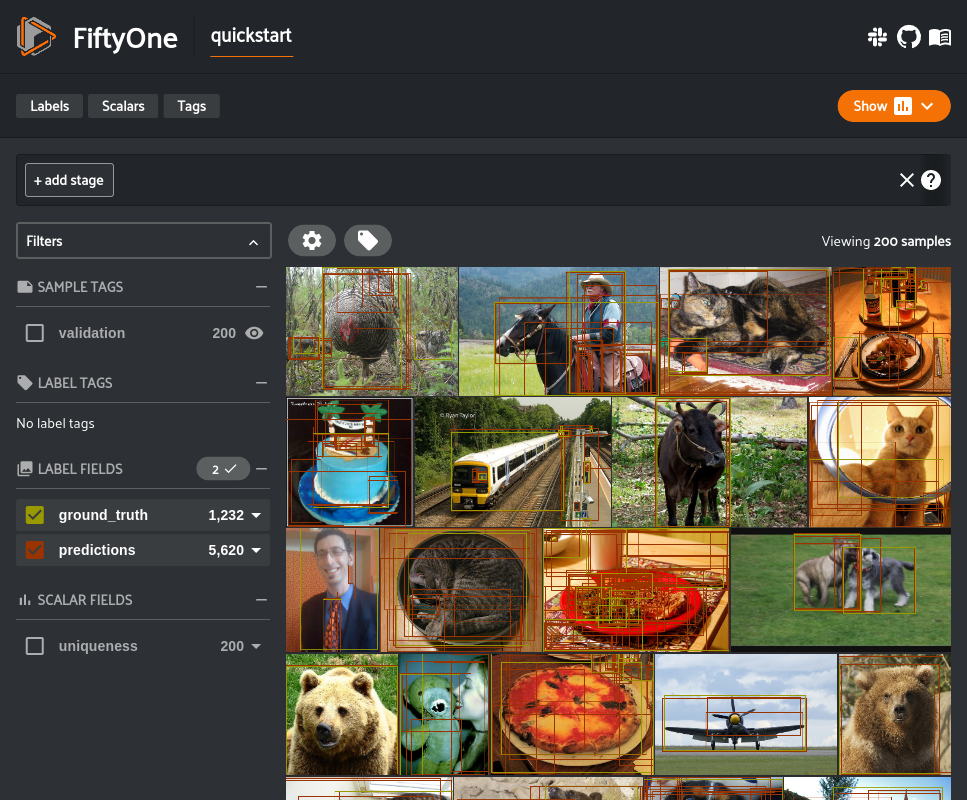

In [4]:
# Open the dataset in the App
session = fo.launch_app(dataset)

## Compute mistakenness

Now we're ready to assess the mistakenness of the ground truth detections.

We can do so by running the [compute_uniqueness()](https://voxel51.com/docs/fiftyone/api/fiftyone.brain.html#fiftyone.brain.compute_mistakenness) method from the FiftyOne Brain:

In [5]:
import fiftyone.brain as fob

# Compute mistakenness of annotations in `ground_truth` field using 
# predictions from `predictions` field as point of reference
fob.compute_mistakenness(dataset, "predictions", label_field="ground_truth")

Evaluating detections...
 100% |█████████████████| 200/200 [4.6s elapsed, 0s remaining, 33.4 samples/s]      
Computing mistakenness...
 100% |█████████████████| 200/200 [3.6s elapsed, 0s remaining, 43.9 samples/s]      
Mistakenness computation complete


The above method populates a number of fields on the samples of our dataset as well as the ground truth and predicted objects:

New ground truth object attributes (in `ground_truth` field):

- `mistakenness` (float): A measure of the likelihood that a ground truth object's label is incorrect
- `mistakenness_loc`: A measure of the likelihood that a ground truth object's localization (bounding box) is inaccurate
- `possible_spurious`: Ground truth objects that were not matched with a predicted object and are deemed to be likely spurious annotations will have this attribute set to True

New predicted object attributes (in `predictions` field):

- `possible_missing`: If a highly confident prediction with no matching ground truth object is encountered, this attribute is set to True to indicate that it is a likely missing ground truth annotation

Sample-level fields:

- `mistakenness`: The maximum mistakenness of the ground truth objects in each sample
- `possible_spurious`: The number of possible spurious ground truth objects in each sample
- `possible_missing`: The number of possible missing ground truth objects in each sample

## Analyzing the results

Let's use FiftyOne to investigate the results.

First, let's show the samples with the most likely annotation mistakes:

In [6]:
from fiftyone import ViewField as F

# Sort by likelihood of mistake (most likely first)
mistake_view = dataset.sort_by("mistakenness", reverse=True)

# Print some information about the view
print(mistake_view)

Dataset:        quickstart
Media type:     image
Num samples:    200
Tags:           ['validation']
Sample fields:
    filepath:          fiftyone.core.fields.StringField
    tags:              fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:          fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.Metadata)
    ground_truth:      fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    uniqueness:        fiftyone.core.fields.FloatField
    predictions:       fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    mistakenness:      fiftyone.core.fields.FloatField
    possible_missing:  fiftyone.core.fields.IntField
    possible_spurious: fiftyone.core.fields.IntField
View stages:
    1. SortBy(field_or_expr='mistakenness', reverse=True)


In [7]:
# Inspect some samples and detections
# This is the first detection of the first sample
print(mistake_view.first().ground_truth.detections[0])

<Detection: {
    'id': '5f452487ef00e6374aad2744',
    'attributes': BaseDict({
        'area': <NumericAttribute: {'value': 16273.3536}>,
        'iscrowd': <NumericAttribute: {'value': 0.0}>,
    }),
    'tags': BaseList([]),
    'label': 'tv',
    'bounding_box': BaseList([
        0.002746666666666667,
        0.36082,
        0.24466666666666667,
        0.3732,
    ]),
    'mask': None,
    'confidence': None,
    'index': None,
    'mistakenness': 0.005771428346633911,
    'mistakenness_loc': 0.16955941131917984,
}>


Let's use the App to visually inspect the results:


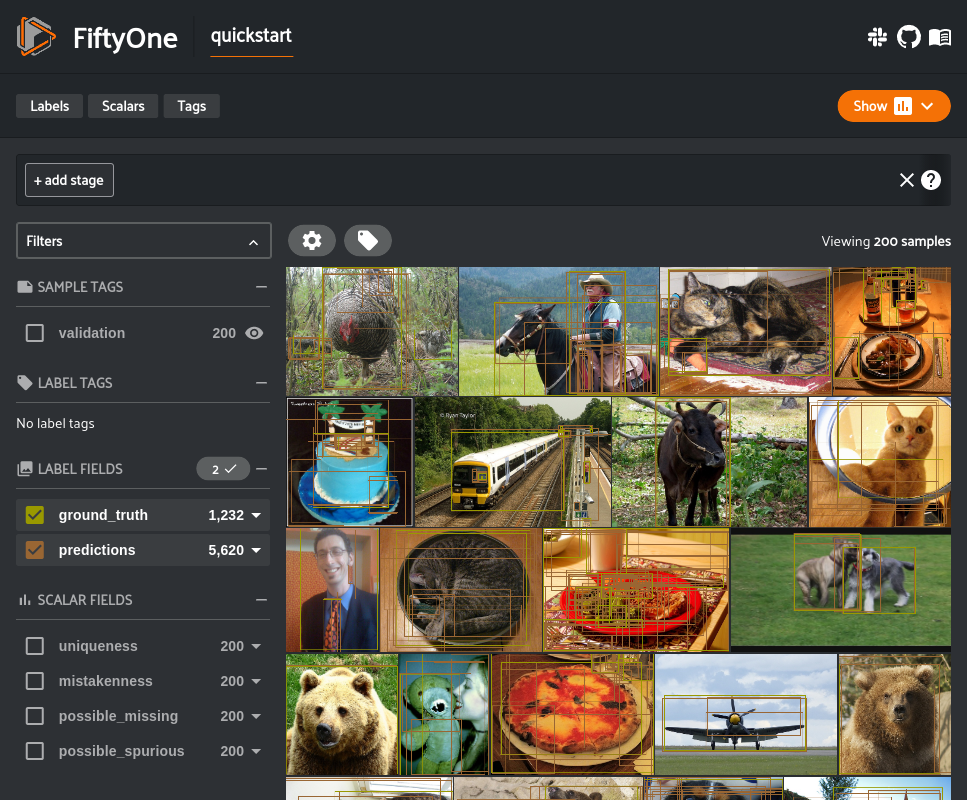

In [8]:
# Open new App window
session.show()


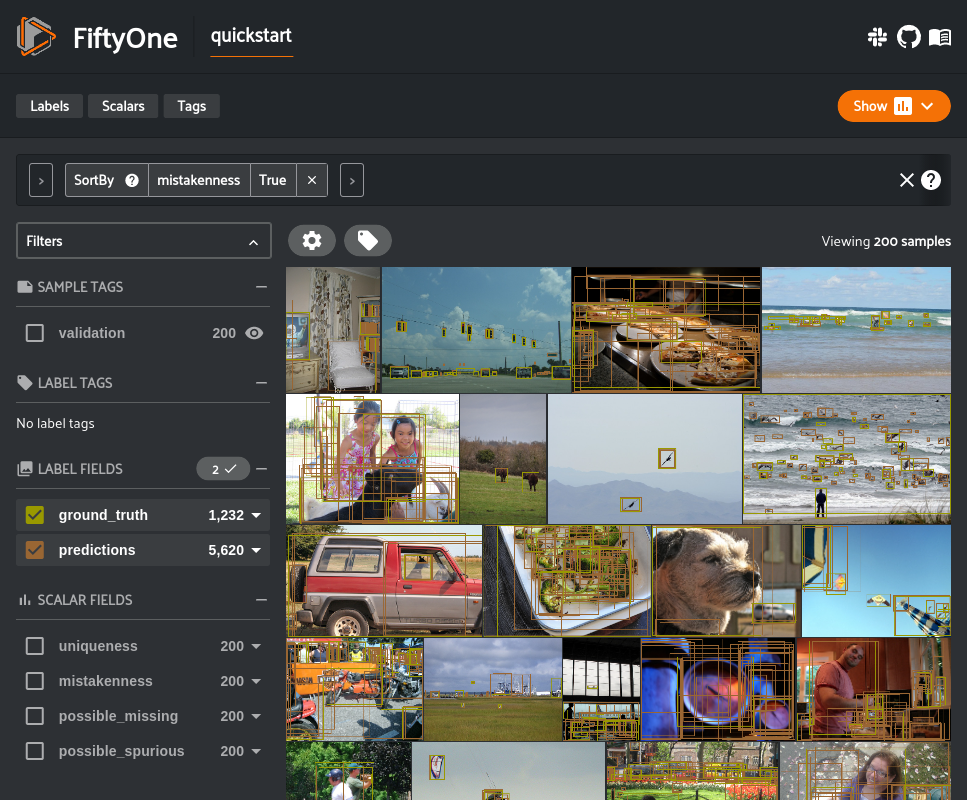

In [9]:
# Show the samples we processed in rank order by the mistakenness
session.view = mistake_view

Another useful query is to find all objects that have a high mistakenness, lets say > 0.95:


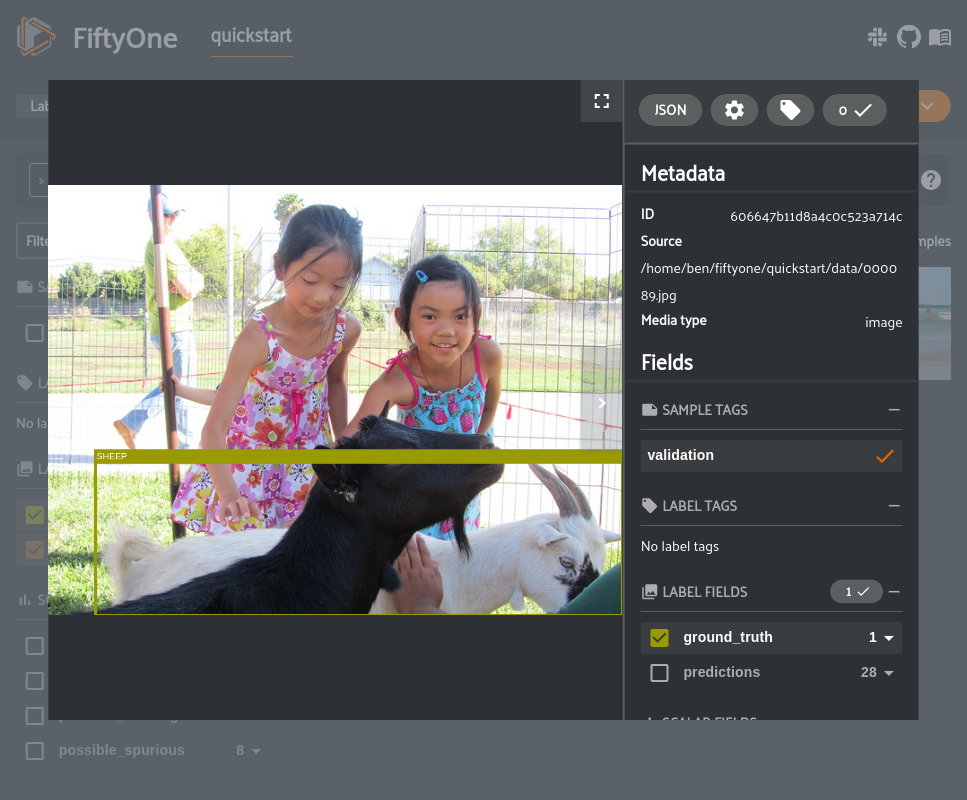

In [10]:
from fiftyone import ViewField as F

session.view = dataset.filter_labels("ground_truth", F("mistakenness") > 0.95)

Looking through the results, we see some annotations that may be incorrect. For example, in the image below the `goat` is labeled as a `sheep`.

We can use a similar workflow to look at objects that may be localized poorly:


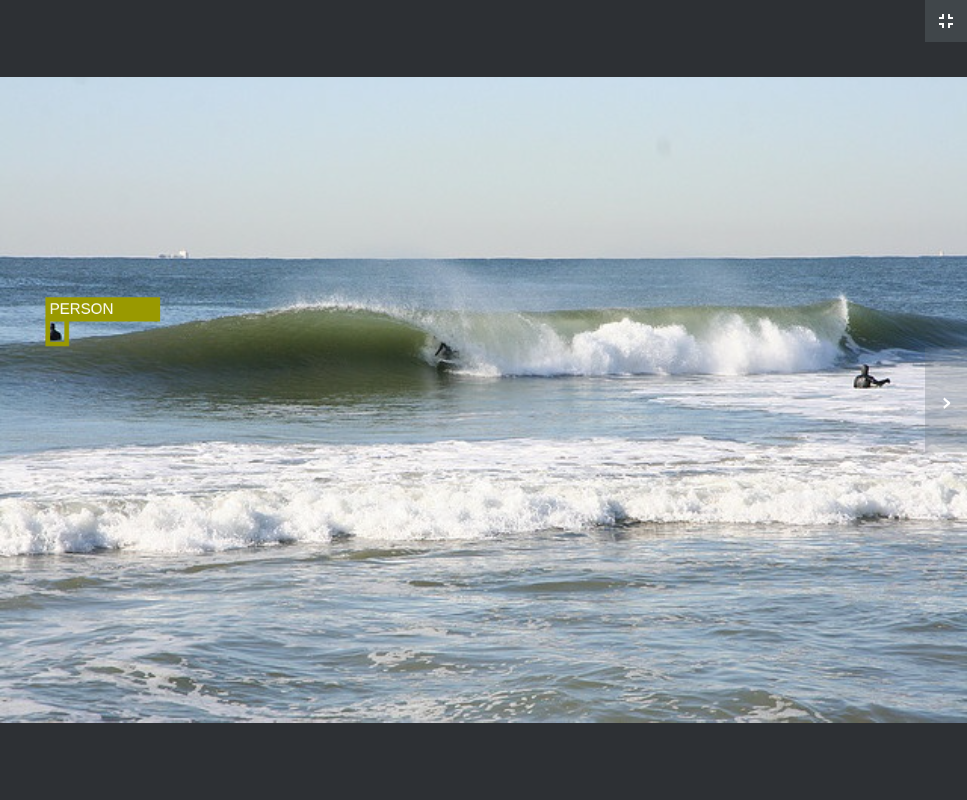

In [11]:
session.view = dataset.filter_labels("ground_truth", F("mistakenness_loc") > 0.95)

One of the examples that popped up from this query is shown below. The bounding box around the person on the left side of the image is shifted too far to the right.

The `possible_missing` field can also be useful to sort by to find instances of incorrect annotations.

Similarly, `possible_spurious` can be used to find objects that the model detected that may have been missed by annotators.


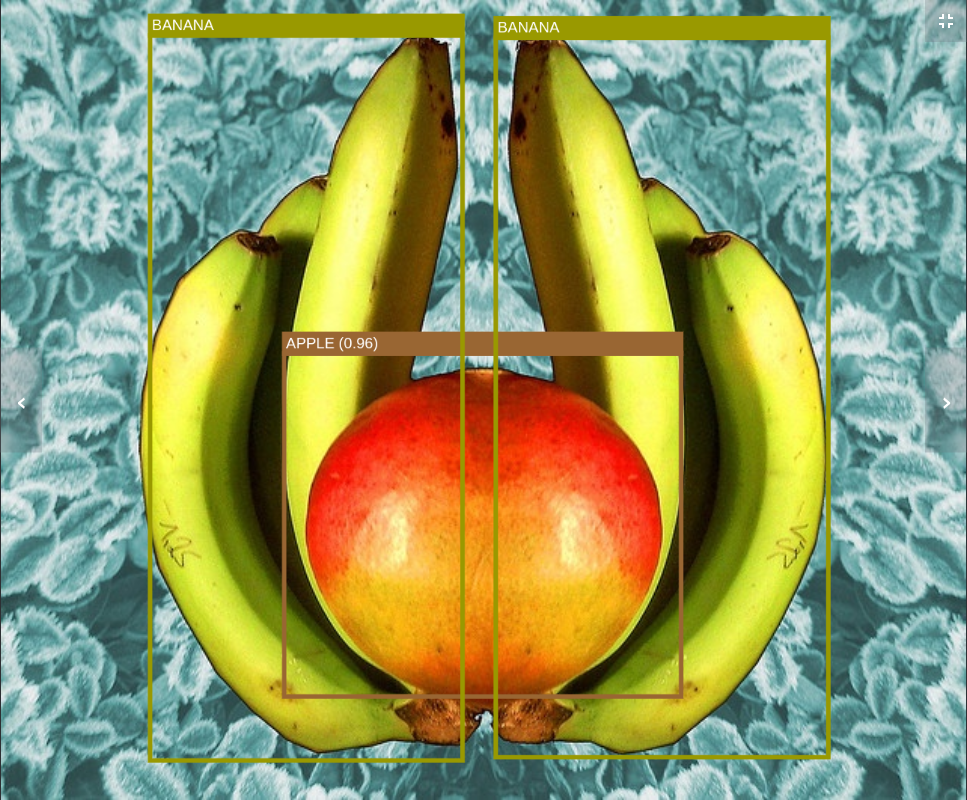

In [12]:
session.view = dataset.match(F("possible_missing") > 0)

An example that showed up from this search is shown above. There is an `apple` that was not annotated that the model detected.

## Tagging and resolution

Any label or collection of labels can be tagged at any time in the sample grid or expanded sample view. In the expanded sample view, individual samples can be selected by clicking on them in the media player. We can, for example, tag this `apple` prediction as `missing` and any other predictions without an associated ground truth detection.

Labels with specific tags can then be selected with [`select_labels()`](https://voxel51.com/docs/fiftyone/api/fiftyone.core.collections.html?highlight=select_labels#fiftyone.core.collections.SampleCollection.select_labels) stage and sent off to assist in improving the annotations with your annotation provided of choice. FiftyOne currently offers integrations for both [Labelbox](https://voxel51.com/docs/fiftyone/api/fiftyone.utils.labelbox.html) and [Scale](https://voxel51.com/docs/fiftyone/api/fiftyone.utils.scale.html).

In [14]:
# A dataset can be filtered to only contain labels with certain tags
# Helpful for isolating labels with issues and sending off to an annotation provider
missing_ground_truth = dataset.select_labels(tags="missing")

**REMEMBER**: Since you are using model predictions to guide the mistakenness process, the better your model, the more accurate the mistakenness suggestions. Additionally, using logits of confidence scores will also provide better results. 

We used Faster-RCNN in this example which is quite a few years old. Using EfficientDet D7 provided much better results. For example, it was easily able to find this `snowboard` labeled as `skis`:

![skis](images/det_mistakenness_6.png)

In [13]:
session.freeze() # screenshot the active App for sharing